[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

In the next few sessions, we'll build towards a chatbot that has long-term memory and start with context management approaches like filtering and trimming

In [25]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [26]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Model
Different models may have different context window size.
* Check here for OpenAI models: https://platform.openai.com/docs/models
* To check context window size in transformer-based models in Hugging Face you need to look into 'max_position_embeddings' field 'config.json' in repo files https://huggingface.co/Qwen/QwQ-32B/blob/main/config.json

In [27]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo") # Q: what is the context window size for GPT-3.5-turbo, GPT-4o?

## Large Context and Attention Spread in LLMs
This example demonstrates how processing a large list of messages can influence a model's attention, influencing its output. It highlights the importance of **filtering context** in agent-based systems to **ensure accuracy and save money**!

Let's consider synthetic example: llm is given a list of integers 1..N where M integers are missed. The task of llm is to detect missing numbers.

In [28]:
import random
import ast

# Generate a large list of numbers
N = 1001 # Q: what will happen if I change to 1001? 10001?
M = 50 # Q: what will happen if I change M to 10? 100?

full_list = list(range(1, N))  # 1 to N
removed_numbers = random.sample(full_list, M)  # Remove 50 random numbers
incomplete_list = [num for num in full_list if num not in removed_numbers]

def get_prompt(large_input, n) -> str:
    return (f"Here is a list of numbers from 1 to {n} (some are missing): {large_input}\n"
              f"Can you identify which numbers are missing? Return ONLY python list of missing numbers.")

# Function to simulate an LLM's attention limitation
def ask_llm(prompt: str) -> list[int]:
    response = llm.invoke(prompt)
    # Transform output to python code. Not safe, in case of failure rerun
    return ast.literal_eval(response.content)

In [29]:
# Run simulation
prompt = get_prompt(incomplete_list, N)
detected = ask_llm(prompt)
print(f"Detected missing numbers (model's response): {detected}")
print(f"Actual missing numbers: {removed_numbers}")

# Show difference
missed = set(removed_numbers) - set(detected)
success = set(detected) - set(missed)
wrong = set(detected) - set(removed_numbers)
if missed:
    print(f"Numbers the model failed to detect: {missed}")
    print(f"Numbers the model succeeded to detect: {success}")
    print(f"Wrong numbers detected by the model: {wrong}")
else:
    print("The model correctly detected all missing numbers!")

Detected missing numbers (model's response): [17, 35, 60, 72, 92, 96, 100, 114, 143, 149, 157, 192, 201, 203, 217, 248, 280, 313, 319, 321, 338, 341, 346, 357, 360, 364, 375, 398, 470, 497, 537, 578, 589, 611, 634, 642, 662, 671, 682, 712, 732, 796, 810, 820, 836, 880, 900, 920, 950, 990]
Actual missing numbers: [321, 157, 248, 17, 357, 92, 313, 375, 671, 578, 374, 611, 203, 143, 642, 60, 634, 537, 799, 346, 796, 880, 72, 100, 96, 149, 418, 489, 820, 421, 732, 470, 341, 836, 35, 724, 201, 364, 114, 360, 589, 810, 280, 192, 990, 454, 497, 319, 662, 712]
Numbers the model failed to detect: {418, 421, 454, 489, 724, 374, 799}
Numbers the model succeeded to detect: {642, 900, 398, 143, 17, 149, 662, 280, 537, 920, 796, 157, 671, 35, 682, 810, 820, 950, 313, 60, 319, 192, 321, 578, 836, 72, 201, 712, 203, 589, 338, 341, 470, 217, 346, 92, 732, 990, 96, 611, 100, 357, 360, 364, 880, 497, 114, 375, 248, 634}
Wrong numbers detected by the model: {900, 682, 398, 338, 950, 920, 217}


## Tiktoken
To estimate the number of tokens, you can use tiktoken library https://pypi.org/project/tiktoken/

In [30]:
import tiktoken

# Initialize the tokenizer for a specific model (e.g., "gpt-4" or "gpt-3.5-turbo")
model_name = "gpt-3.5-turbo"
enc = tiktoken.encoding_for_model(model_name)

# Tokenize and count tokens
tokens = enc.encode(prompt)
token_count = len(tokens)

# Display results
print(f"Token Count: {token_count}")

Token Count: 2885


## Agent's Context
Messages content form the context of the llm in agents. Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model. That is why blindly passing all messages from state to the llm is not always a good idea, so we want to manage them.

Let's first define a simple graph with `MessagesState`

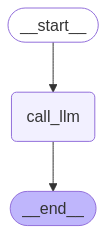

In [31]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def call_llm(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("call_llm", call_llm)
builder.add_edge(START, "call_llm")
builder.add_edge("call_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
from langchain_core.messages import HumanMessage, AIMessage

# Message list with a preamble
messages = [
    HumanMessage(f"Hi! I'm Lance!", id="1"),
    AIMessage(f"Hi, Lance! How can I help you?", id="2"),
    HumanMessage(f"I'm doing research about Cyprus, what I should know?", id="3"),
]

result = graph.invoke({'messages': messages})

for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I'm Lance!
================================== Ai Message ==================================

Hi, Lance! How can I help you?
================================ Human Message =================================

I'm doing research about Cyprus, what I should know?
================================== Ai Message ==================================

Cyprus is an island country located in the Mediterranean Sea, south of Turkey and southeast of Greece. Here are some key points you should know about Cyprus:

1. Cyprus is known for its rich history and diverse cultural influences. It has been inhabited since ancient times and has been ruled by various empires including the Greeks, Romans, Byzantines, and Ottomans.

2. The island is divided between the Republic of Cyprus in the south and the self-declared Turkish Republic of Northern Cyprus in the north. This division came about following a conflict in 1974 and conti

## Option №1: Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

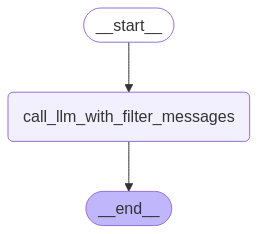

In [33]:
# Node
def call_llm_with_filter_messages(state: MessagesState):
    filtered_messages = state["messages"][-2:]
    message = llm.invoke(filtered_messages)
    return {"messages": [message]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("call_llm_with_filter_messages", call_llm_with_filter_messages)
builder.add_edge(START, "call_llm_with_filter_messages")
builder.add_edge("call_llm_with_filter_messages", END)
graph_with_filter_messages = builder.compile()

# View
display(Image(graph_with_filter_messages.get_graph().draw_mermaid_png()))

In [34]:
# Invoke, using message filtering
output = graph_with_filter_messages.invoke({'messages': messages}) # Q: What you messages you expect in output?
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I'm Lance!
================================== Ai Message ==================================

Hi, Lance! How can I help you?
================================ Human Message =================================

I'm doing research about Cyprus, what I should know?
================================== Ai Message ==================================

That's great! Here are some key points about Cyprus that you should know for your research:

1. Geography: Cyprus is an island country located in the Eastern Mediterranean Sea. It is the third largest island in the Mediterranean.

2. History: Cyprus has a rich history dating back to ancient times, with influences from various civilizations including the Greek, Roman, Byzantine, and Ottoman empires.

3. Culture: The culture of Cyprus is a blend of Greek, Turkish, and Middle Eastern influences. The official languages are Greek and Turkish, and the majority religion is 

In [35]:
output = graph_with_filter_messages.invoke({
    'messages': output['messages'] + [HumanMessage(f"What is my name?")] # Q: What you messages you expect in the output?
})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I'm Lance!
================================== Ai Message ==================================

Hi, Lance! How can I help you?
================================ Human Message =================================

I'm doing research about Cyprus, what I should know?
================================== Ai Message ==================================

That's great! Here are some key points about Cyprus that you should know for your research:

1. Geography: Cyprus is an island country located in the Eastern Mediterranean Sea. It is the third largest island in the Mediterranean.

2. History: Cyprus has a rich history dating back to ancient times, with influences from various civilizations including the Greek, Roman, Byzantine, and Ottoman empires.

3. Culture: The culture of Cyprus is a blend of Greek, Turkish, and Middle Eastern influences. The official languages are Greek and Turkish, and the majority religion is 

The state has all the messages, but because first to messages are not passed to the context, we miss information about the name

## Option №2: RemoveMessage

`RemoveMessage` is a special type of message, which you can put into the `messages` list setting the message id you want to delete. The deletion will be executed by `add_messages` reducer while applying state diff.

So the possible solution can be as following: let's just delete the first messages in chat, leaving only the 2 most recent messages

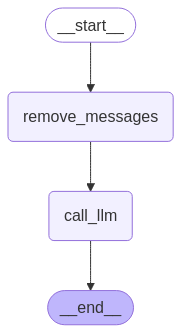

In [36]:
from langchain_core.messages import RemoveMessage

# Nodes
def remove_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def call_llm(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("remove_messages", remove_messages)
builder.add_node("call_llm", call_llm)
builder.add_edge(START, "remove_messages")
builder.add_edge("remove_messages", "call_llm")
builder.add_edge("call_llm", END)
graph_with_remove_message = builder.compile()

# View
display(Image(graph_with_remove_message.get_graph().draw_mermaid_png()))

In [37]:
# Invoke
output = graph_with_remove_message.invoke({'messages': messages}) # Q: What you messages you expect in the output?
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================

Hi, Lance! How can I help you?
================================ Human Message =================================

I'm doing research about Cyprus, what I should know?
================================== Ai Message ==================================

That's great! Cyprus is a fascinating country with a rich history and vibrant culture. Here are some key points to consider for your research:

1. Location: Cyprus is an island country located in the Eastern Mediterranean Sea, south of Turkey and west of Syria and Lebanon.

2. History: Cyprus has a long and complex history that dates back to ancient times. The island has been ruled by various civilizations, including the Greeks, Romans, Byzantines, and Ottomans. In 1960, Cyprus gained independence from British colonial rule.

3. Division: Cyprus is a divided country, with the northern part of the island being controlled by the self-declared Turkish Republic of N

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [38]:
# Invoke
output = graph_with_remove_message.invoke({
    'messages': messages + [output['messages'][-1]] + [HumanMessage(f"What is my name?", id="4")]})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================

That's great! Cyprus is a fascinating country with a rich history and vibrant culture. Here are some key points to consider for your research:

1. Location: Cyprus is an island country located in the Eastern Mediterranean Sea, south of Turkey and west of Syria and Lebanon.

2. History: Cyprus has a long and complex history that dates back to ancient times. The island has been ruled by various civilizations, including the Greeks, Romans, Byzantines, and Ottomans. In 1960, Cyprus gained independence from British colonial rule.

3. Division: Cyprus is a divided country, with the northern part of the island being controlled by the self-declared Turkish Republic of Northern Cyprus, recognized only by Turkey. The southern part is the internationally recognized Republic of Cyprus.

4. Culture: Cyprus has a diverse cultural heritage influenced by its history and geography. The island's cuisine, music, and dance r

In [39]:
# Q: What is the advantage of RemoveMessage from filtering?

## Option №3: Trimming messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

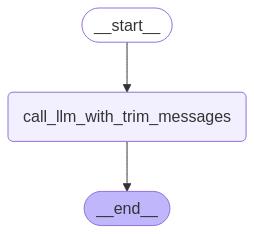

In [40]:
from langchain_core.messages import trim_messages

# Node
def call_llm_with_trim_messages(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-3.5-turbo"),
            allow_partial=True,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("call_llm_with_trim_messages", call_llm_with_trim_messages)
builder.add_edge(START, "call_llm_with_trim_messages")
builder.add_edge("call_llm_with_trim_messages", END)
graph_with_trim_messages = builder.compile()

# View
display(Image(graph_with_trim_messages.get_graph().draw_mermaid_png()))

In [41]:
# Invoke, using message filtering
output = graph_with_trim_messages.invoke({'messages': messages})

enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

for m in output['messages']:
    m.pretty_print()

for m in output['messages']:
    tokens = enc.encode(m.content)
    print(f"Message {m.id} has {len(tokens)} tokens")

================================ Human Message =================================

Hi! I'm Lance!
================================== Ai Message ==================================

Hi, Lance! How can I help you?
================================ Human Message =================================

I'm doing research about Cyprus, what I should know?
================================== Ai Message ==================================

Cyprus is an island country located in the Eastern Mediterranean Sea. It is known for its rich history, stunning beaches, and vibrant culture. Here are some key points about Cyprus:

1. Geography: Cyprus is the third-largest island in the Mediterranean Sea, with a total area of around 9,250 square kilometers. It is divided into the Republic of Cyprus in the south and the self-declared Turkish Republic of Northern Cyprus in the north.

2. History: Cyprus has a long and complex history, with influences from various civilizations including the Greeks, Romans, Byzantines

In [42]:
# Example of trimming messages
for m in trim_messages(
            output['messages'],
            max_tokens=100,
            strategy="first",
            token_counter=ChatOpenAI(model="gpt-3.5-turbo"),
            allow_partial=True # Q: What is False and last message > max_tokens?
        ):
    m.pretty_print()

================================ Human Message =================================

Hi! I'm Lance!
================================== Ai Message ==================================

Hi, Lance! How can I help you?
================================ Human Message =================================

I'm doing research about Cyprus, what I should know?


In [43]:
output = graph_with_filter_messages.invoke({
    'messages': output['messages'] + [HumanMessage(f"What we were talking about?")]
})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! I'm Lance!
================================== Ai Message ==================================

Hi, Lance! How can I help you?
================================ Human Message =================================

I'm doing research about Cyprus, what I should know?
================================== Ai Message ==================================

Cyprus is an island country located in the Eastern Mediterranean Sea. It is known for its rich history, stunning beaches, and vibrant culture. Here are some key points about Cyprus:

1. Geography: Cyprus is the third-largest island in the Mediterranean Sea, with a total area of around 9,250 square kilometers. It is divided into the Republic of Cyprus in the south and the self-declared Turkish Republic of Northern Cyprus in the north.

2. History: Cyprus has a long and complex history, with influences from various civilizations including the Greeks, Romans, Byzantines

## Task

Implement any of this approach of context management to the chat agent

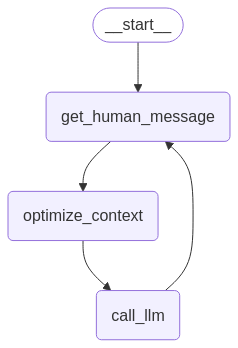

In [48]:
from langchain_core.messages import trim_messages

# Node
def call_llm(state: MessagesState):
    # TODO: implement filtering
    return {"messages": [llm.invoke(state["messages"])]}

def get_human_message(state: MessagesState):
    input_comment = ""
    if len(state["messages"]) != 0:
        input_comment += f"LLM: {state['messages'][-1].content}"
    human_message = input(f"{input_comment}\nEnter your message: ")
    return {"messages": [HumanMessage(human_message)]}

def optimize_context(state: MessagesState):
    # TODO: or implement removing/trimming to short context
    return state

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("call_llm", call_llm)
builder.add_node("get_human_message", get_human_message)
builder.add_node("optimize_context", optimize_context)

builder.add_edge(START, "get_human_message")
builder.add_edge("get_human_message", "optimize_context")
builder.add_edge("optimize_context", "call_llm")
builder.add_edge("call_llm", "get_human_message")

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
graph.invoke({})

KeyboardInterrupt: Interrupted by user